In [21]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc,roc_auc_score, precision_recall_curve, average_precision_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings
from sklearn.model_selection import StratifiedKFold
import numpy as np
import shap
from sklearn.ensemble import RandomForestClassifier


warnings.filterwarnings("ignore")

In [22]:
train = pd.read_excel('../data/final_train.xlsx')
test = pd.read_excel('../data/final_test.xlsx')
oot = pd.read_excel('../data/final_oot.xlsx')

##### random forest avec les données discretisées avec l'encodage hot one comme pour le modèle de régression logistique

In [23]:
CRTOC_AG_NBJCRE_2T_IND_0009= {0:1, 1:0}
CRTOC_AG_LIGDEB_2T_IND_0015 = {0:1, 1:0} 
CRTOC_AG_MVTAFF_2T_IND_0010= {0:2, 1:1, 2:0} 
CRTOC_MOY_MVTAFF_IND_0010 = {0:2, 1:1, 2:0} 

train['CRTOC_AG_NBJCRE_2T_IND_0009'] = train['CRTOC_AG_NBJCRE_2T_IND_0009'].map(CRTOC_AG_NBJCRE_2T_IND_0009)
test['CRTOC_AG_NBJCRE_2T_IND_0009'] = test['CRTOC_AG_NBJCRE_2T_IND_0009'].map(CRTOC_AG_NBJCRE_2T_IND_0009)
oot['CRTOC_AG_NBJCRE_2T_IND_0009'] = oot['CRTOC_AG_NBJCRE_2T_IND_0009'].map(CRTOC_AG_NBJCRE_2T_IND_0009)

train['CRTOC_AG_LIGDEB_2T_IND_0015'] = train['CRTOC_AG_LIGDEB_2T_IND_0015'].map(CRTOC_AG_LIGDEB_2T_IND_0015)
test['CRTOC_AG_LIGDEB_2T_IND_0015'] = test['CRTOC_AG_LIGDEB_2T_IND_0015'].map(CRTOC_AG_LIGDEB_2T_IND_0015)
oot['CRTOC_AG_LIGDEB_2T_IND_0015'] = oot['CRTOC_AG_LIGDEB_2T_IND_0015'].map(CRTOC_AG_LIGDEB_2T_IND_0015)

train['CRTOC_AG_MVTAFF_2T_IND_0010'] = train['CRTOC_AG_MVTAFF_2T_IND_0010'].map(CRTOC_AG_MVTAFF_2T_IND_0010)
test['CRTOC_AG_MVTAFF_2T_IND_0010'] = test['CRTOC_AG_MVTAFF_2T_IND_0010'].map(CRTOC_AG_MVTAFF_2T_IND_0010)
oot['CRTOC_AG_MVTAFF_2T_IND_0010'] = oot['CRTOC_AG_MVTAFF_2T_IND_0010'].map(CRTOC_AG_MVTAFF_2T_IND_0010)

train['CRTOC_MOY_MVTAFF_IND_0010'] = train['CRTOC_MOY_MVTAFF_IND_0010'].map(CRTOC_MOY_MVTAFF_IND_0010)
test['CRTOC_MOY_MVTAFF_IND_0010'] = test['CRTOC_MOY_MVTAFF_IND_0010'].map(CRTOC_MOY_MVTAFF_IND_0010)
oot['CRTOC_MOY_MVTAFF_IND_0010'] = oot['CRTOC_MOY_MVTAFF_IND_0010'].map(CRTOC_MOY_MVTAFF_IND_0010)

In [24]:
variables = train.columns.tolist()
variables.remove('DDefaut_NDB')

X_train = train[variables]
X_test = test[variables]
X_oot = oot[variables]

y_train = train['DDefaut_NDB']
y_test = test['DDefaut_NDB']
y_oot = oot['DDefaut_NDB']

# Convertir toutes les colonnes en type 'category'
X_train = X_train.apply(lambda col: col.astype('category'))
X_test = X_test.apply(lambda col: col.astype('category'))
X_oot = X_oot.apply(lambda col: col.astype('category'))

# Appliquer l'encodage One-Hot sur toutes les colonnes catégorielles
X_train_encoded = pd.get_dummies(X_train, drop_first=False)
X_test_encoded = pd.get_dummies(X_test, drop_first=False)
X_oot_encoded = pd.get_dummies(X_oot, drop_first=False)

# Convertir les colonnes booléennes en entiers (0/1)
X_train_encoded = X_train_encoded.astype(int)
X_test_encoded = X_test_encoded.astype(int)
X_oot_encoded = X_oot_encoded.astype(int)

AUC (Random Forest): 0.886
GINI (Random Forest): 0.772
AUC: 0.886
GINI: 0.772


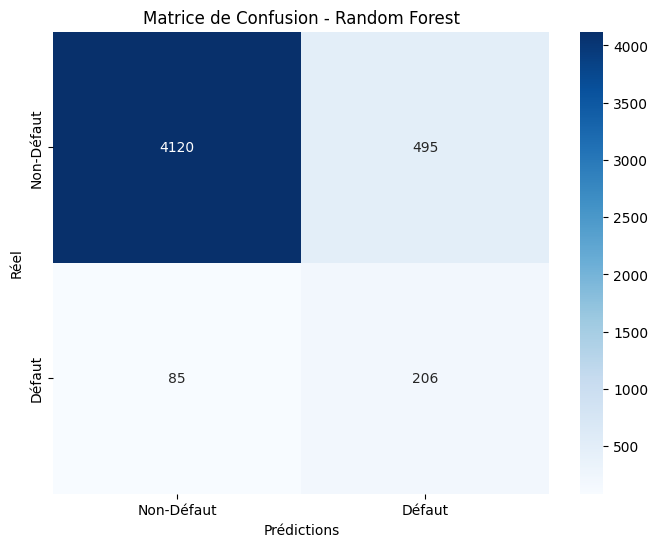

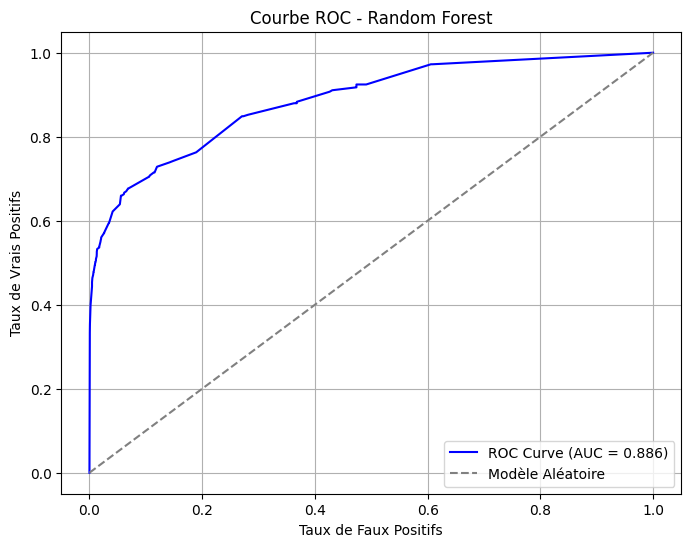

In [25]:
# Initialisation du modèle Random Forest
rf_model = RandomForestClassifier(
    n_estimators=500,       # Nombre d'arbres
    max_depth=3,           # Profondeur maximale des arbres
    class_weight="balanced",# Gestion des classes déséquilibrées
    random_state=42,
    n_jobs=-1               # Utilisation de tous les cœurs disponibles
)

# Entraînement final et évaluation
rf_model.fit(X_train_encoded, y_train)
y_pred_prob_rf_test = rf_model.predict_proba(X_test_encoded)[:, 1]
auc_rf = roc_auc_score(y_test, y_pred_prob_rf_test)
gini_rf = (2 * auc_rf) - 1
print(f"AUC (Random Forest): {auc_rf:.3f}")
print(f"GINI (Random Forest): {gini_rf:.3f}")


# Prédictions sur l'ensemble de test
y_pred_prob = rf_model.predict_proba(X_test_encoded)[:, 1]  # Probabilité de la classe positive
y_pred = rf_model.predict(X_test_encoded)                  # Classe prédite

# Évaluation du modèle
auc = roc_auc_score(y_test, y_pred_prob)
gini = (2 * auc) - 1
print(f"AUC: {auc:.3f}")
print(f"GINI: {gini:.3f}")

# Matrice de confusion
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Défaut', 'Défaut'], yticklabels=['Non-Défaut', 'Défaut'])
    plt.xlabel('Prédictions')
    plt.ylabel('Réel')
    plt.title('Matrice de Confusion - Random Forest')
    plt.show()

plot_confusion_matrix(y_test, y_pred)

# Courbe ROC

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Modèle Aléatoire")
plt.xlabel("Taux de Faux Positifs")
plt.ylabel("Taux de Vrais Positifs")
plt.title("Courbe ROC - Random Forest")
plt.legend(loc="lower right")
plt.grid()
plt.show()

##### random forest sans la discrétisation des variables

In [26]:
train = pd.read_excel('../data/tr.xlsx')
test = pd.read_excel('../data/te.xlsx')
oot = pd.read_excel('../data/o.xlsx')

AUC (Random Forest): 0.896
GINI (Random Forest): 0.792
AUC: 0.896
GINI: 0.792


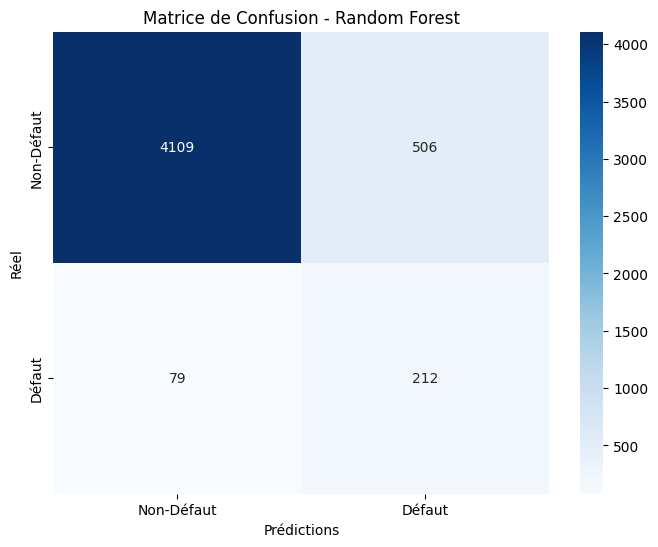

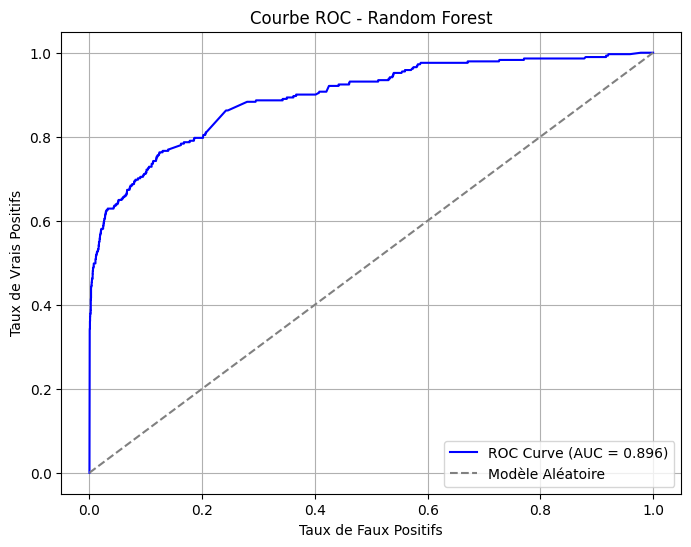

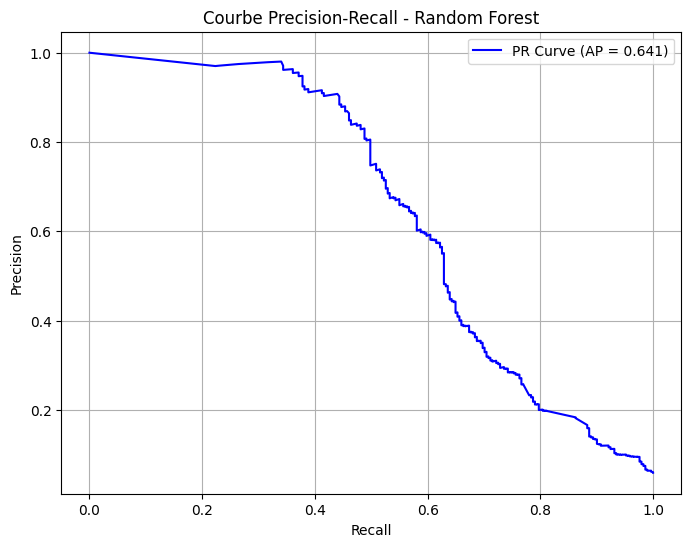

AUC PR: 0.641


In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Sélection des variables et de la cible
variables = train.columns.tolist()
variables.remove('DDefaut_NDB')  # 'DDefaut_NDB' est la variable cible

X_train = train[variables]
X_test = test[variables]
X_oot = oot[variables]

y_train = train['DDefaut_NDB']
y_test = test['DDefaut_NDB']
y_oot = oot['DDefaut_NDB']

# Standardisation des variables explicatives (centrage et réduction)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_oot_scaled = scaler.transform(X_oot)

# Initialisation du modèle Random Forest
rf_model = RandomForestClassifier(
    n_estimators=500,       # Nombre d'arbres
    max_depth=3,            # Profondeur maximale des arbres
    class_weight="balanced", # Gestion des classes déséquilibrées
    random_state=42,
    n_jobs=-1                # Utilisation de tous les cœurs disponibles
)

# Entraînement final et évaluation sur l'ensemble d'entraînement
rf_model.fit(X_train_scaled, y_train)
y_pred_prob_rf_test = rf_model.predict_proba(X_test_scaled)[:, 1]
auc_rf = roc_auc_score(y_test, y_pred_prob_rf_test)
gini_rf = (2 * auc_rf) - 1
print(f"AUC (Random Forest): {auc_rf:.3f}")
print(f"GINI (Random Forest): {gini_rf:.3f}")

# Prédictions sur l'ensemble de test
y_pred_prob = rf_model.predict_proba(X_test_scaled)[:, 1]  # Probabilité de la classe positive
y_pred = rf_model.predict(X_test_scaled)                    # Classe prédite

# Évaluation du modèle
auc = roc_auc_score(y_test, y_pred_prob)
gini = (2 * auc) - 1
print(f"AUC: {auc:.3f}")
print(f"GINI: {gini:.3f}")

# Matrice de confusion
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Défaut', 'Défaut'], yticklabels=['Non-Défaut', 'Défaut'])
    plt.xlabel('Prédictions')
    plt.ylabel('Réel')
    plt.title('Matrice de Confusion - Random Forest')  # Mise à jour du titre
    plt.show()

plot_confusion_matrix(y_test, y_pred)

# Courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Modèle Aléatoire")
plt.xlabel("Taux de Faux Positifs")
plt.ylabel("Taux de Vrais Positifs")
plt.title("Courbe ROC - Random Forest")  # Mise à jour du titre
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Courbe Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
avg_precision = average_precision_score(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"PR Curve (AP = {avg_precision:.3f})", color="blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Courbe Precision-Recall - Random Forest")  # Mise à jour du titre
plt.legend(loc="best")
plt.grid()
plt.show()

print(f"AUC PR: {avg_precision:.3f}")


In [34]:
# rf_explainer = shap.TreeExplainer(rf_model)
# rf_shap_values = rf_explainer.shap_values(X_test_scaled)

# # shap.summary_plot(rf_shap_values, X_test_scaled, feature_names=X_test.columns, plot_type="dot", title="XGBoost - SHAP Summary")

# # Histogramme Simpliﬁé des Valeurs de Shapley pour XGBoost
# rf_df = pd.DataFrame(rf_shap_values, columns=X_test.columns)
# rf_df.abs().mean().sort_values(ascending=False).plot(kind='bar', figsize=(10, 6), title="Importance Globale des Variables (XGBoost)")
# plt.ylabel("Valeur Moyenne Absolue des Shapley")
# plt.xlabel("Variables")
# plt.show()